# MobileNetv2 trained on imagestream and cytopix data

## 2024-08-01



In [2]:
import cv2
import os
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [4]:
import tensorflow as tf
import keras

print(tf.__version__)
tf.random.set_seed(42)
keras.backend.clear_session()

2024-08-01 15:32:16.320176: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 15:32:16.336442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 15:32:16.359664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 15:32:16.359717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 15:32:16.374566: I tensorflow/core/platform/cpu_feature_gua

2.16.2


In [5]:
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
)

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_test, y_pred, class_names):

    fig, ax = plt.subplots(figsize=(8, 8))
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        display_labels=class_names,
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")

In [7]:
def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

In [8]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/imagestream"

Preparing train and test split

In [54]:
from keras.layers import (
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomTranslation,
    RandomContrast,
    RandomBrightness,
)

AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "holly_leaf", "granular", "sickle", "echinocyte"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)

rescale = tf.keras.Sequential([Rescaling(1.0 / 255)])
data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomTranslation(0.2, 0.2),
        RandomContrast(0.2),
        RandomBrightness(0.2),
    ]
)


def prepare(ds, augment=False):

    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

Found 14674 files belonging to 5 classes.
Using 11740 files for training.
Using 2934 files for validation.


In [55]:
class_names = test_ds.class_names

train_ds = prepare(train_ds, augment=True)
test_ds = prepare(test_ds)


for data, label in train_ds.take(1):
    print(f"Train data shape: {data.shape}, label shape: {label.shape}")

Train data shape: (32, 64, 64, 3), label shape: (32,)


2024-08-01 16:21:04.665875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train data shape: (32, 64, 64, 3), label shape: (32,)


2024-08-01 16:20:37.517254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
EPOCHS = 200

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

earlystopper = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)


def learning_rate_schedule(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()


lr_scheduler = keras.callbacks.LearningRateScheduler(learning_rate_schedule)

Training on ImageStream data

In [16]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, ReLU
from keras.regularizers import L2


mobile_net = keras.applications.MobileNetV2(
    input_shape=(64, 64, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

model = Sequential()

model.add(mobile_net)
mobile_net.trainable = True

model.add(Dense(1024, kernel_regularizer=L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(1024, kernel_regularizer=L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(512, kernel_regularizer=L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation="softmax"))  # Final layer with softmax activation


model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

/tmp/ipykernel_1806945/2381439935.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_net = keras.applications.MobileNetV2(


In [17]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [18]:
with tf.device("GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
    )

Epoch 1/200


I0000 00:00:1722519492.552580 1807491 service.cc:145] XLA service 0x7fda28003060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722519492.552627 1807491 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-01 15:38:14.613090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 15:38:20.139236: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1722519502.051118 1809481 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1722519504.668997 1809473 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 1040 bytes spill stores, 1036 bytes spill loads



  3/367 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.2240 - loss: 30.3628   

I0000 00:00:1722519515.947499 1807491 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1722519515.985294 1807491 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4672 - loss: 11.6757

I0000 00:00:1722519527.089188 1809957 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1722519529.769138 1809958 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 1040 bytes spill stores, 1036 bytes spill loads



367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4673 - loss: 11.6577

I0000 00:00:1722519547.856173 1810387 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1722519550.788135 1810385 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 1040 bytes spill stores, 1036 bytes spill loads



367/367 ━━━━━━━━━━━━━━━━━━━━ 79s 100ms/step - accuracy: 0.4674 - loss: 11.6398 - val_accuracy: 0.4039 - val_loss: 2.3749 - learning_rate: 0.0010
Epoch 2/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5452 - loss: 1.2491 - val_accuracy: 0.4032 - val_loss: 10.0693 - learning_rate: 0.0010
Epoch 3/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5528 - loss: 1.1917 - val_accuracy: 0.4145 - val_loss: 3.5720 - learning_rate: 0.0010
Epoch 4/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5846 - loss: 1.1066 - val_accuracy: 0.6673 - val_loss: 1.0916 - learning_rate: 0.0010
Epoch 5/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5978 - loss: 1.1439 - val_accuracy: 0.3845 - val_loss: 1.5025 - learning_rate: 0.0010
Epoch 6/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5725 - loss: 1.1112 - val_accuracy: 0.7243 - val_loss: 1.0092 - learning_rate: 0.0010
Epoch 7/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5899 - loss: 1.0

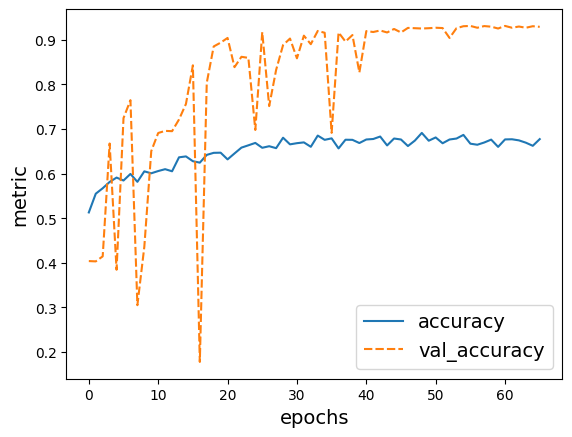

In [20]:
plot_history(history, ["accuracy", "val_accuracy"])

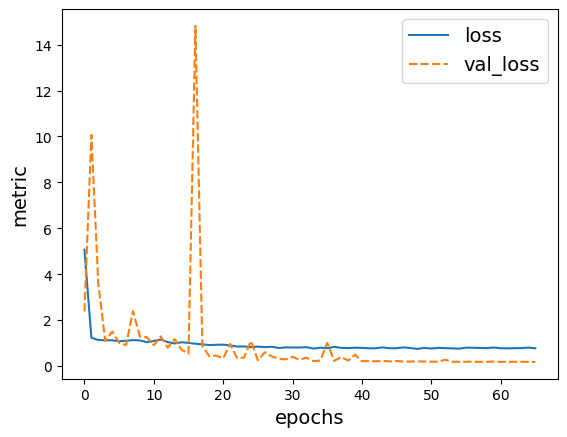

In [21]:
plot_history(history, ["loss", "val_loss"])

In [32]:
y_test = tf.concat([y for x, y in test_ds], axis=0)
y_train = tf.concat([y for x, y in train_ds], axis=0)

2024-08-01 15:52:25.163094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-01 15:52:25.779886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step


In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       1.00      1.00      1.00      1183
  holly_leaf       0.82      0.84      0.83       263
    granular       0.90      0.89      0.90       880
      sickle       0.93      0.92      0.92       162
  echinocyte       0.88      0.89      0.89       446

    accuracy                           0.93      2934
   macro avg       0.90      0.91      0.91      2934
weighted avg       0.93      0.93      0.93      2934



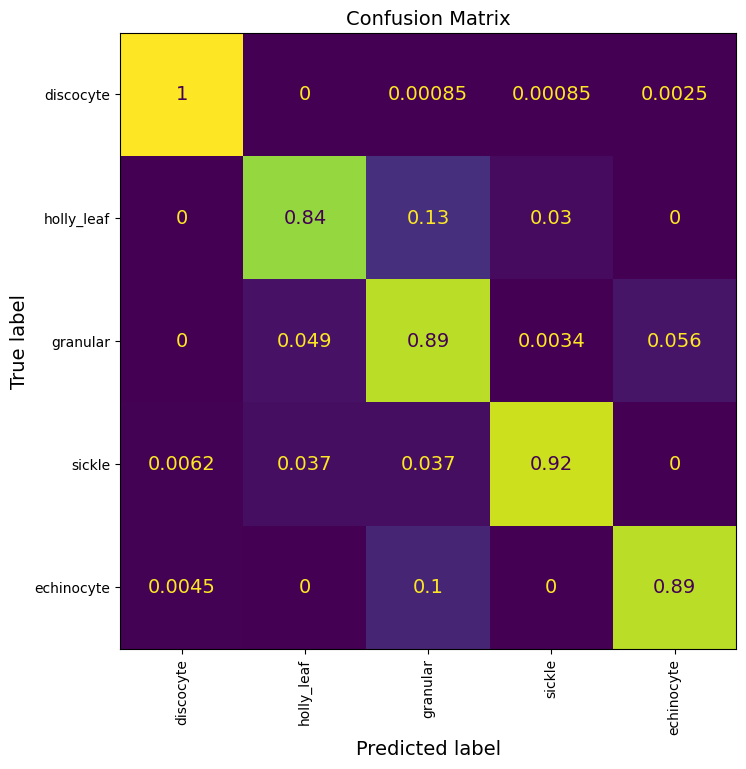

In [36]:
get_confusion_matrix(y_test, y_pred, class_names)

In [57]:
model.save_weights(
    "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v02.weights.h5"
)

Retrain part of the model on the cytopix